<a href="https://www.kaggle.com/code/afi1289/a-comprehensive-guide-to-text-preprocessing?scriptVersionId=113379465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-family:verdana;"> <center> First Step in NLP: 
    Understand your Textual Data and Prepare it for ML/DL Model 🔥</center> </h1>
<p><center style="color:#159364; font-family:cursive;">Strive for Excellence, Not Perfection</center></p>

***

Performing initial data investigation is the first step in every data science project. Looking at data would help us to comprehend its structure, discover patterns and to evaluate data quality.

This is a starter notebook for NLP in text processing. It will show you how to summarize and visualize your textual data to gain valuable intuition and understanding of your NLP project. It covers Text Preprocessing and Analysis in comprehensive details. 

> - The notebook is inspired by this **amazing book**: [Blueprints for Text Analytics Using Python: Machine Learning-Based Solutions for Common Real World (NLP) Applications](https://www.amazon.de/Blueprints-Text-Analytics-using-Python/dp/149207408X) by *Jens Albrecht, Sidharth Ramachandran, and Christian Winkler*. The authors explain the fundamentals of NLP, while also putting it directly into practice. Code examples are available in the [Github repository](https://github.com/blueprints-for-text-analytics-python/blueprints-text).
> - Other valuable references used in this notebook are: 
>   - [Practical Statistics for Data Scientists: 50+ Essential Concepts Using R and Python](https://www.amazon.de/Practical-Statistics-Data-Scientists-Essential/dp/149207294X)
>   - [Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython](https://www.amazon.de/Python-Data-Analysis-Wrangling-IPython/dp/1491957662)
>   - [Advanced NLP with spaCy](https://course.spacy.io/en)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; If you find this notebook useful in anyway, please upvote it so that it can reach a bigger audience 🔥. You can share it with your fellow kagglers.
</div>

<h1 style='background:#F9545F; border:0; border-radius: 10px; color:black'><center> TABLE OF CONTENTS </center></h1>

### [**1.Importing Libraries and Loading Data**](#title-one)

### [**2.Get Familiar with your Dataset**](#title-two)

### [**3.Build a Text Preprocessing Pipeline: Data Cleaning**](#title-three)
    
### [**4.Build a Text Preprocessing Pipeline: Linguistic Processing**](#title-four) 
    

<a id="title-one"></a>
<h1 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Importing Libraries and Loading Data</center></h1>

In [ ]:
# install textacy
!pip install textacy

In [ ]:
# import libraries 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = None # uncomment to show the entire text
pd.options.mode.chained_assignment = None

# visualization using plotly
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read specific columns in the dataset into a pandas dataframe
df = pd.read_csv("../input/russia-ukraine-conflict/ukraine_conflict.csv", parse_dates=['date'], usecols= ["date", 
                                                                                    "time",
                                                                                    "username", 
                                                                                    "name", 
                                                                                    "place", 
                                                                                    "tweet", 
                                                                                    "video"])

df

## Large dataset? Take a sample, Develop your code, and Rerun! 
If you have a large dataset, start with a subset of the original dataset using Pandas `sample` function or use `pd.read_csv` parameters such as `nrows`. This allows to develop your code and visualizations quickly and avoid performance problems. Once you are done, you can rerun your code on the large dataset to get the full insight.

In [ ]:
# return a subset from the original corpus
df_subset = df.sample(frac = 0.05)
df_subset.head(2)

## Language Detection with fastText

There are different trained models available on the fastText website. We will be using the smaller model `lid.176.ftz` which has a size of less than 1 MB and is almost as accurate as the large model with 126MB. See <https://fasttext.cc/docs/en/language-identification.html> for instructions.

In [ ]:
# download model
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

In [ ]:
import fasttext

lang_model = fasttext.load_model("lid.176.ftz")

# make a prediction
lang_model.predict('"Good morning" in German is "Guten Morgen"', 3)

> **NOTE**: This is just a deprecation warning, related to compatibility with older versions of a python library. You can safely ignore it.

The `predict` function takes two arguments:
1. Unicode string as its first argument. 
2. The second, optional parameter `k` specifies that we want the `k` language labels with the highest probabilities.

The model returns labels in the form `__label__<code>`, where code is the ISO 639 language code`<footnote>`See <https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes> for a complete list.`</footnote>` and probabilites for each label. 

Let's wrap the language identification into a preprocessing function. The function returns the detected language only if the calculated probability is higher than the specified threshold, otherwise, it returns the default language. This is useful for corpora like the hacker news, which is basically an English corpus with some utterances from other languages.

In [ ]:
import fasttext
def predict_language(text, threshold=0.8, default='en'):

    # fasttext requires single line input
    text = text.replace('\n', ' ')
    
    
    labels, probas = lang_model.predict(text)
    lang = labels[0].replace("__label__", "") # remove __label__
    proba = probas[0]
    
    if proba < threshold:
        return default
    else:
        return lang

In [ ]:
# create new columns for tweet and name language
df['language_tweet'] = df['tweet'].apply(predict_language)
df["language_name"] = df['name'].apply(predict_language)

# check Non-English tweets 
df[df["language_tweet"]!="en"].head()

<a id="title-two"></a>
<h1 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>GET FAMILIAR WITH YOUR DATASET</center></h1>

Before starting the *real* analysis, let's gather some information about the structure of our dataset:

In [ ]:
# add new column with tweet's length
df['length'] = df['tweet'].str.len()

# compute the summary statistics for the columns
df[["length"]].describe().T

In [ ]:
df[["name", "tweet", "language_tweet", "language_name"]].describe(include="O").T

The table above shows that there are tweets in 42 different languages. As expected, English is the most frequent language with 40160 English tweets

### Check for Missing Values
By looking at the values in the `place` column we remark that it has some missing values. The missing data are represented as floating-point value Not a Number `NaN` (aka sentinel value). Let's check missing values in our dataset:

In [ ]:
# show the number of NaN in each column
df.isnull().sum()

The table above shows that most of the information in the `place` column is **not**  available! Before we deal with this column, Let's check if this column has any useful information in the non-null elements:

In [ ]:
# check non-null elements 
df[df["place"].notnull()].head()

There are 3 methods for handling missing data:
1. Drop rows/columns containing `NaN` values using `df.dropna()` 
2. Fill in missing data using `df.fillna()`
3. Flag rows contining missing data

We are going to substitute the missing values in `place` column using other value such as `unknown`:

In [ ]:
# fillna returns a new object, but you can modify the existing object inplace (so be careful :) )
df["place"].fillna("unkown", inplace=True)

However, we know that this column is not useful. Thus, we can delete it:

In [ ]:
del df["place"]

For more detailed information about handling missing values check the following sources: 
* [Python for Data Analysis](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython-ebook/dp/B075X4LT6K) *p.193 - 195*
* The great data cleaning challenge notebooks by Rachael Tatman [Data Cleaning Challenge: Handling missing values](https://www.kaggle.com/code/rtatman/data-cleaning-challenge-handling-missing-values/notebook)
---

We can also find tweets that contain a specific word or hastag:

In [ ]:
# check tweets containing #StopWar hashtag 
df[df["tweet"].str.contains("#stopwar", case=False)].head() # case insensitive

### Explore the Data Distribution

To visualize the distribution of text lengths, we will use a boxplot. **Note**: We will change pandas plotting backend to get interactive `plotly` using plotly backend instead of matplotlib static plots. 

> A **boxplot**- with the top and bottom of the box at the 75th and 25th percentiles, respectively-also gives a quick sense of the distribution of the data, it is often used in side-by-side displays to compare distributions. 

\- [Practical Statistics for Data Science: 50+ Essential Concepts Using R and Python](https://www.amazon.de/Practical-Statistics-Data-Scientists-Essential/dp/149207294X) *p. 26*

In [ ]:
# show the boxplot for the length column
df["length"].plot(kind="box")

What can be clearly see in this boxplot, half of the tweets (the box in the middle) fall between roughly 108 and 252 characters. The top and bottom of the box are the **75th** and **25th percentiles**, respectively. In other words, 25% of the speeches have 108 characters or less.  The **midian** is shown by the horizontal line in the box with 160 characters. The line extend from the top and bottom of the box are the **whiskers** that indicate the range for the bulk of the data. Any data outside of the whiskers is plotted as single points or circles referred to as **outliers**.

To get more details, we will use a histogram to take a sense of the distribution of the tweets' lenghts at a glance. In the following histogram, the value range of the `length` column is divided into **bins** (intervals with the same width). The *y-axis* shows the number of tweets falling into each of these bins. For example, there are 1568 tweets that have between 275 and 279 characters.

In [ ]:
# show the histogram for the length column
df["length"].plot(kind="hist", bins=30)

### Comparing Value Distributions across Categories
Let's compare the distributions of the tweets length over four different languages (Arabic: *ar*, German: *de*, Ukranian: *uk*, and Russian: *ru*) . We will use `plotly.graph_objects` module to create and manipulate graphical figures. 

---
Check `plotly` documentation to learn more about how to create and update figures: 
* [Creating and updating figures](https://plotly.com/python/creating-and-updating-figures/#figures-as-graph-objects).
* [Plotly API Reference](https://plotly.com/python-api-reference/)
* [update_layout() method](https://plotly.com/python/reference/layout/#layout-title)

In [ ]:
# select a subset of countries
x_data = ['ar', 'de', 'uk',"ru"]

# find the tweet length for each language
y_data = [df[df["language_tweet"] == lang]["length"].to_numpy() for lang in x_data]

# choose colors for your plot (optional)
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)']

# create figure instance
fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
    # each trace will capture the values for a country
        fig.add_trace(go.Box(
            y=yd,
            name=xd,          # Sets the trace name
            boxpoints='all',  # All sample points are shown
            jitter=0.5,       # Sets the amount of jitter in the sample points drawn
            whiskerwidth=0.2, # Sets the width of the whiskers relative to the box’ width
            fillcolor=cls,
            marker_size=5,
            line_width=2)
        )

# we use update_layout() method to update multiple nested nested properties of a figure's layout
fig.update_layout(
    title='Box plots visualizing the distribution of tweet lenghts for selected languages',
    margin=dict( # set margins for left, right, bottom, and top
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)', # Sets the background color of the paper where the graph is drawn
    plot_bgcolor='rgb(243, 243, 243)',  # Sets the background color of the plotting area in-between x and y axes
    showlegend=False,
)

fig.show()

**Violin Plot** is an enhancement to the boxplot as it can show nuances in the distribution that aren't preceptible in a boxplot. We can combine a violin plot with a boxplot by adding `box_visible=True` when adding or updating the trace.

In [ ]:
# select a subset of countries
x_data = ['ar', 'de', 'uk',"ru"]

# find the tweet length for each language
y_data = [df[df["language_tweet"] == lang]["length"].to_numpy() for lang in x_data]

# choose colors for your plot (optional)
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)']

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Violin( ##
            y=yd,
            name=xd,
            legendgroup = "F",
            jitter=0.5,
            scalegroup = "M",
            fillcolor=cls,
            marker_size=5,
            line_width=1,
            box_visible=True) ##
        )

fig.update_layout(
    title='Box plots visualizing the distribution of tweet lenghts for selected languages',
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)        
        
fig.update_traces(#box_visible=True, 
                  meanline_visible=True, 
                  points = "all")


fig.show()

Both plots show that the despresion of tweets lengths for German (*de*) is musch larger than other languages. 

### Visualizing Developments Over Time
Since our dataset contains time element, it is worth visualizing some trends over the time. For example, let's see how the number of tweets changes during the day. First, let's infer hours from string:

In [ ]:
# convert string column into time
df["time"] = pd.to_datetime(df['time'])#.dt.time

# the same step to return hours only
df["time_hour"] = pd.to_datetime(df['time'],format= '%H:%M:%S').dt.hour

Now, we will use `groubpy("column_name")` method, which splits the data based on condition/column into groups (based on the column `time` in our case) then count the rows (i.e., tweets) in each group. Then, we can simply append `.plot()` to visualize the result:

In [ ]:
df.groupby("time_hour").size().plot(title="Number of tweets during the day", kind="line")

As expected, the users are more active during daytime. Could you find how the number of German tweets during the day? 
Let's use pandas `query` function, which enables us to filter the data just like where clause in SQL. This function helps in compiling several conditions simultaneously in a memory-efficient manner as it does not uses temporary variables.

---
* Check this [article](https://towardsdatascience.com/10-examples-that-will-make-you-use-pandas-query-function-more-often-a8fb3e9361cb) about pandas `query` function

In [ ]:
df.query("language_tweet == 'de'").groupby("time_hour").size().plot(title="Number of German tweets during the day", kind="line")

# or
#df[df["language_tweet"] == "ar"].groupby("time_hour").size().plot(title="Number of German tweets during the day", kind="line")


We can also use `pd.Grouper` on `time` column directly, which allows seamless aggregation on different date/time granularities:

In [ ]:
df.query("language_tweet == 'de'").groupby(pd.Grouper(key='time', freq='H')).size().plot(kind="line")

<h1 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Build a Text Preprocessing Pipeline</center></h1>

* Our previous analysis has already provided the first insights on the dataset. However, the analysis of the dataset would be more interesting when going deeper into the actual content. To do that, we have to prepare our text in a several different steps. Each step provides the output for the next one, such sequence of processing steps is referred to as **processing pipeline**. Our pipline will transform the source text into prepared tokens. In addition, it should remove the disturbing noise to facilitate detecting patterns in our data. Some examples of noise are *HTML tags* (e.g., `<!DOCTYPE>` or `<body>`)  , *special characters* (e.g., `%#!`), and *stop words* (e.g., `the`, `is`, and `and`). 

### Key notes:
* The **main goal** of any text preprocessing pipeline is to create a **prepared dataset** for analysis or feed it into a machine learning model. 
* However, the requirements for a prepared dataset are **dependent** on the type of NLP task you are working on. If you are working on a sentiment analysis project, you must **NOT** delete valuble information such as stop words or special characters. Look at the following example: 
    * `I didn't like the end of Game of Thrones!!!` If you remove stop words and special characters, you will lose `didn't` and `!!!` altough both are important modifiers that change the orientation and modify the intensity of sentiment term `like`. 
* We will discuss different steps of text preprocessing. Choose **suitable steps** for your project.
* Our pipeline consists of **two building blocks**: Data Cleaning and Linguistic Preprocessing

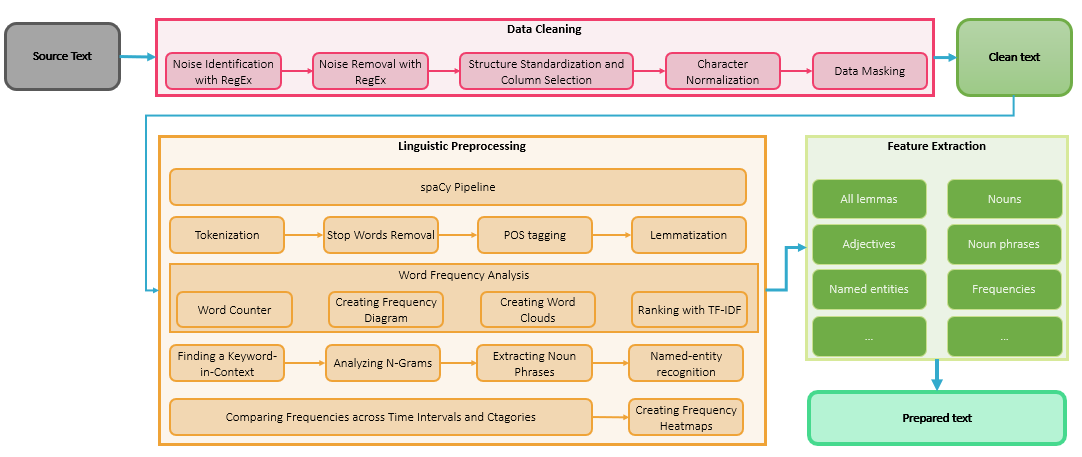

<a id="title-three"></a>
<h2 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Data Cleaning</center></h2>

In order to create a **prepared dataset** we have to clean our text. The first step in data cleaning is to remove unwanted characters. That is, delete all tags, HTML entities, and special characters. Here is where regular expressions can help.

> **Regular Expression or RegEx** is a string containing a combination of normal characters and special metacharacters that describes patters to find text or positions within a text. 

\- Python has `re` module for RegEx. You can use RegEx in different cases, For example:
* Search for *8 characters* followed by *4 digits* in the specified string: `re.search(r"\w{8}\d{4}", "We should avoid passwords like johnsmith1234")`
* Find `@` followed by *one or more characters*, followed by *0 or more non-characters*, followed by *one or more characters* in the specified string: `re.findall(r"@\w+\W*\w+", "The show is amazing! @ahmad!a @sam&&n @mary9")`
* Find the string `www` followed by *one or more of any character*, followed by the *string* `de`: `re.findall(r"www.+de", "Click on this link: www.stepstone.de/jobs For more information")`
* Find  a pattern contains *any lowercase or uppercase letters* followed by *a digit* in the specified string: `re.findall(r"[a-zA-Z]+\d", " Your notebook is upvoted by Ahmad8 and John5")`
---
* If you want to learn more about RegEx and the meaning of metachracters check the following sources:
    * [An overview about available metacharacters](https://www.w3schools.com/python/python_regex.asp)
    + [Great tool to illustrate any RegEx](https://regexper.com/)
    * [Interactive website to develop and test RegEx](https://regex101.com/)
    

#### Identify noise with RegEx:
We will a function that uses RegEx to identify the rate of **noise** (i.e., not plain text) in tweets. Such noise affects the quality of our data.

In [ ]:
import re

# define a precompiled regular expression
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """
    Returns the share of suspicious characters in a text.
    Very short texts (less than min_len) are ignored.
    """
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

Our precompiled RegEx will calculate the share of the illustrated characters in the text:

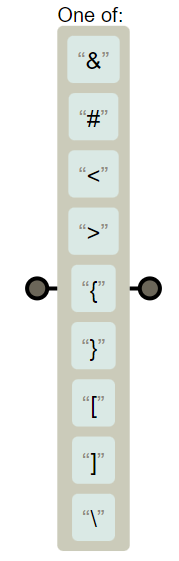

In [ ]:
# an example text with noise and non-English characters
text_1 = """
Check [SIA - Unstoppable](https://youtu.be/ydwBQhpFR1Q)
I'm unstoppable, I'm a Porsche with no Breaks!!!!
<lb>LOVE THIS:<lb><lb>[](/sp)[](/pplovesyou) SIA<lb>[](/sp)[](/abcd)
Captain America<lb>.
朱惠英 
Привет, мир 
こんにちは世界"""

print(f"About {impurity(text_1)*100:.4f}% of characters are suspicious", )

The `impurity()` function has identified the following characters as "suspicious":

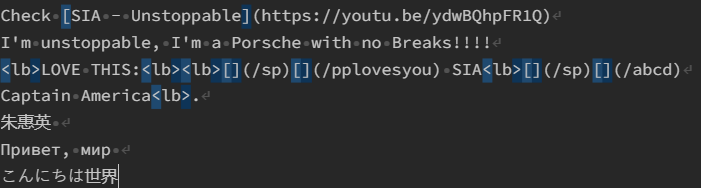

Let's add a new column in our dataframe to calculate the share of suspicious characters in the `text` column. We will use Pandas `apply()` function, which allows applying functions along a row or a cloumn.
> **NOTE** `apply()` function allows us to pass additional parameters of the applied function (in this case `min_lin` of `impurity()` function)

In [ ]:
# add new column to dataframe
df["impurity"] = df["tweet"].apply(impurity, min_len=100)

# get the top 3 tweets
df[['tweet', 'impurity']].sort_values(by='impurity', ascending=False).head(5)

Since some of tweets in our dataset contain only hashtags, our function gave these tweets high impurity rate. In the next step, we will see how we can remove some suspecious characters with RegEx:

#### Noise removal with RegEx:
To clean text data we will apply a set of RegEx to convert problematic patterns into characters or spaces. In addition, it will remove any non-English characters. If you want to test the RegEx on a specific text or develop your own RegEx, check this [Online Tool](https://regex101.com/).

In [ ]:
# define noise removal function
import html

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

We can apply clean function on a sample text:

In [ ]:
# an example text with noise and non-English characters
text_1 = """
Check [SIA - Unstoppable](https://youtu.be/ydwBQhpFR1Q) on Youtube!
I'm unstoppable, I'm a Porsche with no Breaks!!!!
<lb>LOVE THIS:<lb><lb>[](/sp)[](/pplovesyou) SIA<lb>[](/sp)[](/abcd)
Captain America<lb>.
朱惠英 
Привет, мир 
こんにちは世界"""

# apply clean function and save the result
clean_text_1 = clean(text_1)
print(clean_text_1)

# check the share of suspicious characters
print(f"\nAbout {impurity(clean_text_1)*100:.4f}% of characters are suspicious", )

So, `clean()` function works great! We have a relatively clean text now! You can add **further cleaning steps** if necessary. For example, add the following line to `clean()` in order to remove the punctuations:

In [ ]:
del_punc = re.sub(r'[.,]','', clean_text_1)
print(del_punc)

How to apply `clean()` function on a dataframe?

In [ ]:
# create new column with map function, which accepts our clean function
df["clean_text"] = df["tweet"].map(clean)

In [ ]:
df[["clean_text"]]

#### Character normalization:
This process focuses on replacing **umlauts** (e.g., *schön*), **accents** (*è, â, î or ô*), **fancy characters/quotation marks** (𝔄𝔥𝔪𝔞𝔡 𝔄𝔩𝔦𝔰𝔪𝔞𝔦𝔩) with standard characters according to ASCII encoding format. In addition, words that have been split across lines by a hyphen for visual consistency would be joined. In this step, we will use an NLP library called `textacy`. It's an amazing library with a wide range of functions for preprocessing. 

---
See also:
* [textacy Text Preprocessing Documentation](https://textacy.readthedocs.io/en/0.12.0/api_reference/preprocessing.html)

In [ ]:
import textacy
from textacy import preprocessing

# define a normalization function
def normalize(text):
    # join words split by a hyphen or line break
    text = preprocessing.normalize.hyphenated_words(text)
    
    # subsitute fancy quatation marks with an ASCII equivalent
    text = preprocessing.normalize.quotation_marks(text)
    
    # normalize unicode characters in text into canonical forms
    text = preprocessing.normalize.unicode(text)
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    text = preprocessing.remove.accents(text)
    
    return text

In [ ]:
# try normalize function on a text with hyphens, fancy, and accented characters
my_text1 = "Mit Google Lens erfährst du einfach mehr über deine Umgeb-\nung! 𝔄𝔥𝔪𝔞𝔡 𝔄𝔩𝔦𝔰𝔪𝔞𝔦𝔩 𝔦𝔰 𝔞 𝔭𝔞𝔰𝔰𝔦𝔬𝔫𝔞𝔱𝔢 𝔞𝔟𝔬𝔲𝔱 𝔇𝔞𝔱𝔞 𝔖𝔠𝔦𝔢𝔫𝔠𝔢 𝔞𝔫𝔡 𝔐𝔞𝔠𝔥𝔦𝔫𝔢 𝔏𝔢𝔞𝔯𝔫𝔦𝔫𝔤"
print(normalize(my_text1))

In [ ]:
# apply on dataframe
df["clean_text"] = df["clean_text"].map(normalize)

#### Data masking
Your dataset might contain sensitive data (not in this dataset 😊), such as email addresses or phone numbers. Therefore, you must hide (mask) this information. `textacy` provides a set of functions for data masking. Let's define masking function to hide email addresses, phone numbers, userIDs, and URLs.

In [ ]:
import textacy
from textacy import preprocessing

# define masking function
def mask(text):
    
    # replace all email addresses in text with _EmailAddress or remove it
    text = preprocessing.replace.emails(text, repl= "_EmailAddress_")
    
    # replace all phone numbers in text with _PhoneNumber_ or remove it
    text = preprocessing.replace.phone_numbers(text, repl="_PhoneNumber_")
    
    # replace all URLs in text with _URL_ or remove it
    text = preprocessing.replace.urls(text, repl= "_URL_") 
    
    # replace all (Twitter-style) user handles in text with _UserID_
    text = preprocessing.replace.user_handles(text, repl="_UserID_")
    
    return text

In [ ]:
# apply masking function on an example
sensitive_txt = """
            Check out https://www.stasi-unterlagen-archiv.de/ . For more information, contact us at 111-222-3333.
            Or send an email to us at 'ahmad.alismail01@gmail.com' or contact @afi1289.
           """
print(mask(sensitive_txt))

Our text has been masked after modifiying sensitive information. Let's apply `mask()` function to our dataframe to finalize **data cleaning** block.

In [ ]:
# mask sensitive data
df["clean_text"] = df["clean_text"].map(mask)

It is worth mentioning that `textacy` allows composing multiple preprocessing steps into a single callable pipeline. Let's define a callable pipeline that takes a text as input, passes it through one or more functions in **sequential order**, then outputs a single (preprocessed) text string. 
> **NOTE:** To specify arguments for individual preprocessors, you can use `functools.partial()`:

In [ ]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,
    
    
    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,
    
    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " "]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [ ]:
# check the functionality of textacy pipeline
my_text1 = "Mit Google Lens erfährst du einfach mehr über deine Umgeb-\nung! 𝔄𝔥𝔪𝔞𝔡 𝔄𝔩𝔦𝔰𝔪𝔞𝔦𝔩 @𝖆𝖋𝖎1289 𝔦𝔰 𝔞 𝔭𝔞𝔰𝔰𝔦𝔬𝔫𝔞𝔱𝔢 𝔞𝔟𝔬𝔲𝔱 𝔇𝔞𝔱𝔞 𝔖𝔠𝔦𝔢𝔫𝔠𝔢 𝔞𝔫𝔡 𝔐𝔞𝔠𝔥𝔦𝔫𝔢 𝔏𝔢𝔞𝔯𝔫𝔦𝔫𝔤"
my_text2 = "@spacy_io is OSS for <lb><h>industrial-strength</h><lb> NLP in Python developed by @explosion_ai 💥,,,, :; "
my_text3 = "🔥🔥 hacking with my buddy Isaac Mewton #PawProgramming. ::::::;;;;; Worth $ or €"

print(preproc(my_text1))
print("\n",preproc(my_text2))
print("\n",preproc(my_text3))

In [ ]:
# create new column with map function, which accepts our preprocessing pipeline
df["clean_text_textacy"] = df["tweet"].map(preproc)

> **NOTE**: Data Cleaning is an iterative process. There's **always** room for improvement. Stop cleaning when your dataset is **sufficient** clean. As the saying goes: *garbage in, garbage out*. Ensure that you have high-quality data before starting your project because dirty data has an **incremental cost**.

<a id="title-four"></a>
<h2 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Linguistic Processing</center></h2>

The second block in our preprocessing pipeline is linguistic processing, which consists basically of multiple steps: 
1. `Tokenization`: segmenting text into words, punctuations marks etc
2. `Stop Words Removal`: removing most common words of a language that add little or no meaning to the overall sentence, for example “and” or “I”
3. `Part-Of-Speech (POS) tagging`: assigning word types to tokens, like verb or noun
4. `Lemmatization`: assigning the base forms of words. For example, the lemma of “was” is “be”, and the lemma of “rats” is “rat”
5. `Word frequency Analysis`: provide some basic understanding of discussed topics by counting words, creating diagrams, and ranking words.
6. `Advanced Token Analysis`: This step aims to find keywords, analyze n-grams, and extract noun phrases
7. `Named-Entity-Recognition (NER)`: labelling named “real-world” objects, like persons, companies or locations

At the center of `spaCy` is the **trained pipeline model** (e.g., `en_core_web_sm`). We can load it via `spacy.load`. This will return a `Language` object containing all components and data needed to process text. We usually call this object `nlp`. 

When you call `nlp` on a text, `spaCy` first **tokenizes** the text to produce a `Doc` object. The `Doc` is then processed in several different steps – this is also referred to as the **processing pipeline**. The pipeline used by the trained pipelines typically include a **tagger**, a **lemmatizer**, a **parser** and an **entity recognizer.** Each pipeline component returns the *processed* `Doc`, which is then passed on to the next component. 

Let's create an `nlp` **object** (that contains the *shared vocabulary*, the *model*, and the *processing pipeline components*) using an English **trained pipeline model/package** `en_core_web_sm`, which is trained on we text and supports all core capabilites:



In [ ]:
import spacy
# download best-matching version of specific model for your spaCy installation
!python -m spacy download en_core_web_sm

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# check processing pipeline components of nlp object
nlp.pipeline

The pipeline components are: vectorizer, tagger, parser, named-entity recognizer, attribute ruler, and lemmatizer. These components are called on the `Doc` object in order. The tokenizer is NOT explicitly listed as it fundamental step, which runs BEFORE all of components. Some components (e.g., `tok2vec`) have been recently introduced in spaCy v3. Check out [spaCy website](https://spacy.io/usage/spacy-101#pipelines) for more information.


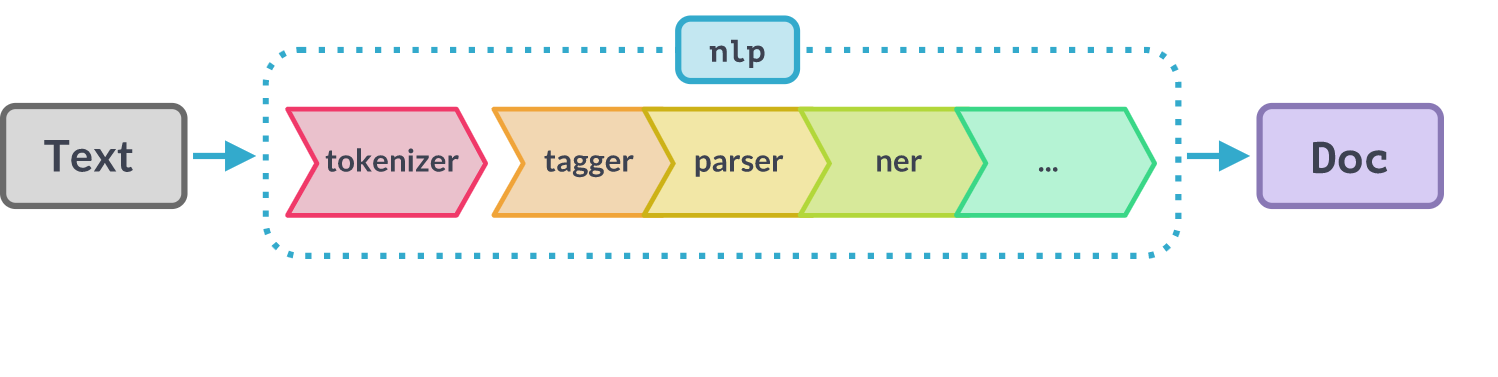

When you process a text with the `nlp` object, `spaCy` creates a `Doc` object – short for "document". The `Doc` lets you access information about the tokens, ranges of tokens (aka spans) and their linguistic annotations. Since `spaCy` is object-oriented no information is lost.

In [ ]:
# create a Doc by processing a string of text with the nlp object
doc = nlp("We are learning the basics of text processing with spaCy")

# iterate over tokens in a Doc
for token in doc:
    print(token.text, end=" | ")

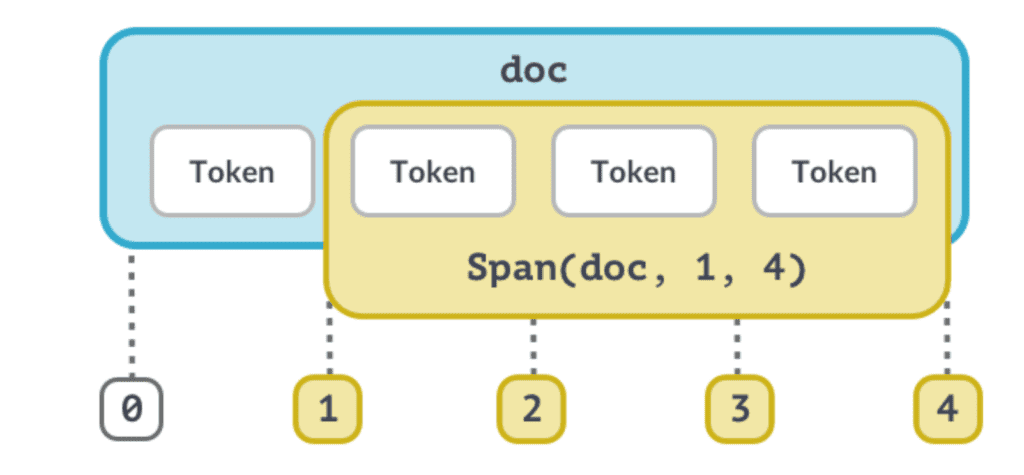

Each tokes represents an object of `spaCy`s class `Token`. To get a token at a specific position, you can index into the `doc`.

In [ ]:
# index into the Doc to get a single Token
tok = doc[2]

# get the token text via the .text attribute
print(tok.text)

`Token` objects also provide various attributes that let you access more information about the tokens:

* `.text`: The original word text.
* `.lemma_`: The base form of the word.
* `.pos_`: The simple UPOS part-of-speech tag.
* `.tag_`: The detailed part-of-speech tag.
* `.dep_`: Syntactic dependency, i.e. the relation between tokens.
* `shape_`: The word shape – capitalization, punctuation, digits.
* `is_alpha`: Is the token an alpha character?
* `is_stop`: Is the token part of a stop list, i.e. the most common words of the language?

> Like many NLP libraries, spaCy **encodes all strings to hash values** to reduce memory usage and improve efficiency. So to get the readable string representation of an attribute, we need to add an underscore `_` to its name

In [ ]:
# print some token attributes
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

In [ ]:
# generate dataframe to visualize tokens and corresponding attributes

def display_nlp(doc, include_punct=False):
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_,
                   'pos_': t.pos_, 'tag_': t.tag_, 'dep_': t.dep_,
                   'shape_': t.shape_, 'is_alpha': t.is_alpha,
                   'is_stop': t.is_stop}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [ ]:
display_nlp(doc)

A `Span` object is a slice of the document consisting of one or more tokens. It's only a view of the `Doc` and **doesn't** contain any data itself.

To create a span, you can use Python's slice notation. For example, `1:4` will create a slice starting from the token at position `1`, up to – but **not** including! – the token at position `4`.

In [ ]:
# a slice from the Doc is a span object
span = doc[1:3]

# get the span text via the .text attribute
print(span.text)

#### Custom Tokenizer
During processing, `spaCy` first tokenizes the text, i.e. segments it into words, punctuation and so on. This is done by applying rules specific to each language. For example, punctuation at the end of a sentence should be split off – whereas “U.K.” should remain one token. Each `Doc` consists of individual tokens, and we can iterate over them:

In [ ]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, end= " | ")

First, the raw text is split on whitespace characters, similar to `text.split(' ')`. Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

1. **Does the substring match a tokenizer exception rule?** For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.
2. **Can a prefix, suffix or infix be split off?** For example punctuation like commas, periods, hyphens or quotes.
If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split **complex, nested tokens** like combinations of abbreviations and multiple punctuation marks.

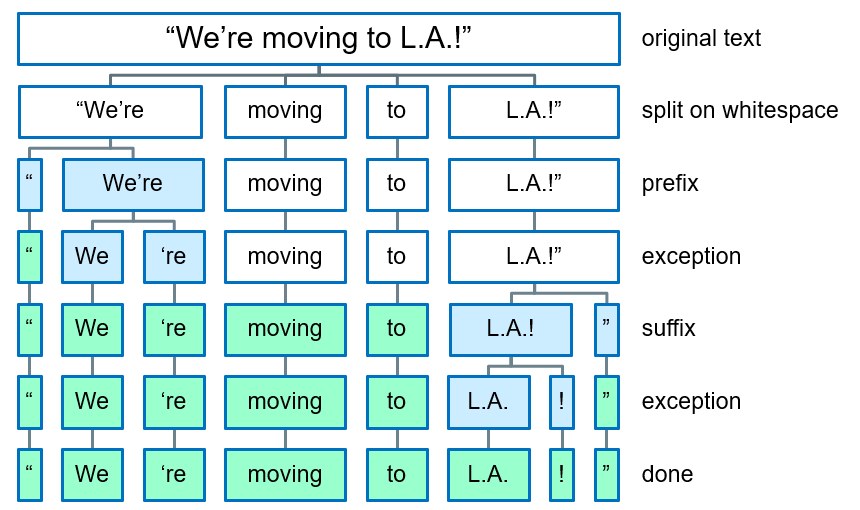
---

* **Tokenizer exception**: Special-case rule to split a string into several tokens or prevent a token from being split when punctuation rules are applied.
* **Prefix**: Character(s) at the beginning, e.g. `$`, `(`, `“`, `¿`
* **Suffix**: Character(s) at the end, e.g. `km`, `)`, `”`, `!`
* **Infix**: Character(s) in between, e.g. `-`, `--`, `/`, `…`.

---
However, it may return wrong tokens because since it splits on hash signs, hyphens, and underscores:

In [ ]:
string = "@afi1289: provide high-quality data #textpreprocessing #data-quality. _url_ ;-) 📌🏆"
doc2 = nlp(string)

for token in doc2:
    print(token.text)

In `spaCy`, we can create our own tokenizer with our own customized rules. For example, if we want to create a tokenizer for a new language, this can be done by defining a new tokenizer method and adding rules of tokenizing to that method. These rules are prefix searches, infix searches, postfix searches, URL searches, and defining special cases.

Let's cutomize `spaCy` tokenizer with inividual rules for prefix, suffix, and infix. The following function creates a tokenizer object by dropping some patterns from `spaCy`'s rules (minimum modification):
> **NOTE:** Be careful with tokenizer customization because changing some rules for a specific case can affect tokenization in other cases. Errors made in this phase will propogate into later phases and cause problems. 

---
* Check out the following link for more about adding special rules, debugging tokenizer, and customization [Tokenization](https://spacy.io/usage/linguistic-features#custom-tokenizer)

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

# customize your spaCy tokenizer
def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

In [ ]:
# change the behaviour of nlp tokenizer
nlp.tokenizer = custom_tokenizer(nlp)

# create a Doc by processing a string of text with the nlp object
doc = nlp(string)

# iterate over tokens in Doc
for token in doc:
    print(token.text)

To apply `spaCy` tokenizer or your custom tokenizer on a column in dataframe, we will use pandas `.apply()` function:
> **NOTE**: `nlp` by default runs the entire `spaCy` pipeline, which includes part-of-speech tagging, parsing and named entity recognition. You can significantly **speed up your code** by using `nlp.tokenizer(x)` instead of `nlp(x)`, or by disabling unneccesary parts of the pipeline when you load the model:

`nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])`

In [ ]:
# tokenize clean text column with our custom tokenizer
# filter hashtags
df["tokens"] = df["clean_text_textacy"].apply(lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')])

Let's create new column containing hashtags only. Therefore, we will define a simple function for this purpose:

In [ ]:
def extract_hashtags(s):
    return [part[1:] for part in s.split() if part.startswith('#')]

In [ ]:
df["hashtags"] = df["clean_text_textacy"].map(extract_hashtags)

In [ ]:
df.head(2)

#### Stop Words Removal
Stop words refer to agroup of words tha occur frequently in natural languages and add little or no meaning to the overall sentence (e.g., `the`, `to`, and `of`). Such words are often removed before analysis or modelling. Most of NLP libraries provide stop words lists. We will work with `spaCy`s to discared stop words here.
> **NOTE:** Removing stop words may be a Dangerous in some NLP tasks since it will change the semantics of a text. For example, if you filter stop words with `spaCy` from "I didn't like this movie", you will have "like this movie"! For sentiment analyis task, you've changed the sentiment polarity calssification from negative to positive!

`spaCy` has a list of 326 stop words. Let's check them:

In [ ]:
# show the current set of stop words in spaCy
stopwords = nlp.Defaults.stop_words
print(len(stopwords))
print(stopwords)

Sometimes, you want to add/remove **custom stop words** to the predefined stop words set. For example, if you are analyzing résumés, terms like "Experience" and "Education" should be filtered since they appear in the majority of documents:

In [ ]:
# add single stop word
nlp.Defaults.stop_words.add("my_new_stopword")
# or
nlp.vocab['my_stopword'].is_stop = True

# add several stopwords at once
# | is a set operator (union)
nlp.Defaults.stop_words |= {"my_new_stopword1","my_new_stopword2",}

# remove a single stopword
nlp.Defaults.stop_words.remove("whatever")
# or
nlp.vocab['my_stopword'].is_stop = False

# remove several stopwords at once
# - is a set operator (difference)
nlp.Defaults.stop_words -= {"whatever", "whenever"}

We can check whether a word is a stop word or not by using the `is_stop` method of `spaCy`:

In [ ]:
# create a Doc by processing a string of text with the nlp object
doc4 = nlp("All things are TOO difficult before they are easy...")

# iterate over tokens in a Doc
for token in doc4:
    print(token.text, token.is_stop)

Most of the tokens in the previous sentence are stop words! Using `is_stop` method, we can remove stop words (and punctuation tokens with `is_punct` method):

In [ ]:
# remove stop words and punctuation tokens
non_stop = [t for t in doc4 if not t.is_stop and not t.is_punct]

# print the list after filtering it out
print(non_stop)

In [ ]:
# create a column of tokenized words that are NOT stop words or punctuations
# filter hashtags
# we are using custom tokenizer
df["tokens_clean"] = df["clean_text_textacy"].apply(lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')
                                                                                               and not t.is_stop 
                                                                                               and not t.is_punct])

In [ ]:
df.head(2)

#### POS filtering
The parser component in the processing pipline of `nlp` object allows assigning word types to tokens, like verb or noun. As mentioned before, `spaCy` provides two Part-of-Speech methods, namely `pos_` (simplified tag **Recommended**) and `tag_` (more detailed tag). The table below illustrates universal POS tags:

Tag | Description | Example 
------------ | ------------ | ------------
`VERB` | verb (all tenses and modus)| run, eat, runs, ate, running, eating
`ADJ` | adjective (modify nouns) | big, first, old, African
`ADP` | adposition (cover term fore prepositions and postpositions) | in, to, during
`ADV` | adverb (modify verbs or adjectives) | very, well, tomorrow, where, there
`AUX` | auxiliary (accompanies the lexical verb) | will (do), must (do), got (done)
`CCONJ` | coordinating conjunction (connects words, phrases, and clauses that are equal to each othe) | FANBOYS (for, and, nor, but, or, yet, so)
`DET` | determiner (modify nouns or noun phrases and express the reference of noun phrase in context) | a (car), my (car), this (car), which (car)
`INTJ` | interjection (a word used as an exclamation, express an emotional reaction) | a (car), my (car), this (car), which (car)
`NOUN` | common nouns only | girl, cat, tree, beauty
`NUM` | numeral | 1, one, I, IV
`PART` | particles (must be associated with another word or phrase) | ‘s
`PRON` | pronoun ( words that substitute for nouns or noun phrases) | I, you, myself, who
`PROPN` | proper noun | Ahmad, Regensburg
`PUNCT` | punctuation marks | , . ()
`SCONJ` | subordinating conjunction (word or phrase that links a dependent clause to an independent clause) | although, before, if
`SYM` | Symbol | $, ♥‿♥, 😝
`X` | anything that cannot be assigned a real POS category | xfgh pdl jklw

We can use POS tags to filter tokens in `doc` as follows:

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# create a Doc by processing a string of text with the nlp object
doc5 = nlp("Apple is looking at buying U.K. startup for $1 billion")

# iterate over tokens in a Doc
for token in doc5:
    print(token.text, token.pos_, end = " | ")

# filter tokens to get verbs and symbols
verbs = [token for token in doc5 if token.pos_ in ["VERB","SYM"]]

print(f"\n\nShow a list of verbs only: {verbs}")

`textacy` provide more general and powerful method for word filtering using `extract.basics.words` function, which extracts words from a document processed by `spaCy` and allows filtering by POS tag and additional token attributes:
> **NOTE**: This function returns generator object. Therefore, you can use `list()` function, list comprehension, or the unpack operator `*` to convert it to a list of `spaCy`s **token objects**.

In [ ]:
import textacy

# extract words from doc object and filter the tokens
# it returns spaCy token objects
verbs2 = textacy.extract.basics.words(doc5,# doc-like object 
            filter_stops = True,           # If True, remove stop words from word list.
            filter_punct = True,           # If True, remove punctuation from word list.
            filter_nums = True,            # If True, remove number-like words (e.g. 10, “ten”) from word list.
            include_pos = ["VERB", "SYM"], # Remove words whose part-of-speech tag IS NOT in the specified tags.
            exclude_pos = None,            # Remove words whose part-of-speech tag IS in the specified tags.
            min_freq = 1)                  # Remove words that occur in doc-like object fewer than min_freq times.

# print the returned list of token objects
print([v for v in verbs2])

# or (you should comment the previous line)
#print(*[v for v in verbs2], sep= " | ")

Let's wrap it in a function:

In [ ]:
def extract_words(doc, **kwargs):
    return [t.text for t in textacy.extract.basics.words(doc, **kwargs)]

In [ ]:
# extract words from spaCys doc object for tokens assigned with ADJ, VERB, NOUN, PROPN, and SYM Part-of-Speech tags
filtered_words = extract_words(doc5, include_pos=["ADJ", "VERB", "NOUN","PROPN", "SYM"])

print(filtered_words)

#### Extract token lemmas
`spaCy` provides `lemma_` method to assign the base forms of words. For example, the lemma of “was” is “be”, and the lemma of “rats” is “rat”. Let's extract lemmas of the following sentence:
> **NOTE**: Using lemmas is not suitable for all NLP applications. Consider the sentence "Worst movie ever!!", using the lemma "bad" instead of "worst" will change the sentiment intensity, which can harm the performance of your sentiment analysis system.

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# create a Doc by processing a string of text with the nlp object
doc5 = nlp("Apple is looking at buying U.K. startup for $1 billion")

# iterate over tokens in a Doc
for token in doc5:
    print(token.text, token.lemma_)

# create a list of lemmas
lemmas = [token.lemma_ for token in doc5]
print(f"\n\nShow a list of lemmas only: {lemmas}")

We can also textract a filtered list of lemmas based on tokens assigned with verbs and symbols POS tags:

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# create a Doc by processing a string of text with the nlp object
doc5 = nlp("Apple is looking at buying U.K. startup for $1 billion")

# extract lemmas for tokens assigned with VERB and SYM Part-of-Speech tags
filtered_lemmas = [token.lemma_ for token in doc5 if token.pos_ in ["VERB", "SYM"]]
print(filtered_lemmas)

More **general** function to extract a **filtered list of word lemmas** is defined by using `textacy.extract.basics.words` function:

In [ ]:
def extract_lemmas(doc, **kwargs):
    
    return [t.lemma_ for t in textacy.extract.basics.words(doc, **kwargs)]

# extract lemmas from spaCys doc object for tokens assigned with ADJ, VERB, NOUN, PROPN, and SYM Part-of-Speech tags
filtered_lemmas2 = extract_lemmas(doc5, include_pos=["ADJ", "VERB", "NOUN","PROPN", "SYM"])

print(filtered_lemmas2)

**IMPORTANT**: You can apply `extract_lemmas` or `extract_words` functions on a column in dataframe after applying `spaCy` pipeline on it. More about using `spaCy` on large datasets will be discussed later in the section "*Using `spaCy`s batch processing `nlp.pipe()`*"

#### Word Frequency Analysis:
In this step we will **calculate** and **visualize** word/hashtags frequencies. In addition, we visuaize these frequencies by different font sizes (i.e., **word clouds**). Finally we will **rank** words with TF-IDF. 

##### Word Counter:
We will use `Counter` class to count the occurrences of each word in a text. It's a container that keeps track of how many times equivalent values are added. `Counter` accepts a **list** as input. In this case, the list would be here **tokenized words** of a `doc`. `Counter` can be updated with a list of tokens of other `doc`s:

In [ ]:
from collections import Counter
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# create a Doc by processing a string of text with the nlp object
doc5 = nlp("Apple is looking at buying U.K. startup for $1 billion")
doc6 = nlp("Buying Apple iPhone in U.K. for 1300$")

# put tokens TEXT in lists 
toks1 = [token.text for token in doc5]
toks2 = [token.text for token in doc6]

# create counter object
counter = Counter(toks1)
print(counter)

counter.update(toks2)
print(counter)

In [ ]:
toks1

The code below count word occurences in dataframe:

In [ ]:
# instantiate counter object
counter_df = Counter()

# count tokens in column containing tokenized words where stop words and punctuations are excluded
# _ is used here to hold the result of the last executed expression in this interactive interpreter session 
_ = df["tokens_clean"].map(counter_df.update)

print(counter_df.most_common(10))

Let's transform the counter into dataframe for more convenient in any further analysis or processing using `count_words()` function, which takes the following parameters:
* `df_name`: name of the dataframe
* `column_name`: column name, where text/tokens are stored
* `preprocess`: custom text processing function for on the fly text preprocessing 
* `min_freq`: minimum fequency of tokens to be included in the result

In [ ]:
from collections import Counter 

# count words in a column of dataframe and return dataframe
def count_words(df_name, column_name, preprocess=None, min_freq=2):

    # define inner function to process tokens and update counter
    def inner_update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens) # update here is counter method

    # create counter and run through all data
    counter = Counter()
    df_name[column_name].map(inner_update) # call inner function

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    # query the columns of a DataFrame with a boolean expression
    freq_df = freq_df.query('freq >= @min_freq')
    # change the index name
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [ ]:
# calculate the frequency of words in the precomputed "tokens_clean" column
freq_df = count_words(df, "tokens_clean")
freq_df

In [ ]:
# calculate the frequency of words in the precomputed "hashtags" column
freq_hashtags = count_words(df, "hashtags")
freq_hashtags

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# change the behaviour of nlp tokenizer
nlp.tokenizer = custom_tokenizer(nlp)

In [ ]:
# generate pandas series of frequencies from the "clean_text_textacy" column 
# preprocess has function to tokenize words and filter stop words, punctuations, and hashtags

freq_df = count_words(df, 
                       "clean_text_textacy",
                        preprocess = lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')
                                                                                and not t.is_stop 
                                                                                and not t.is_punct])
freq_df.head(5)

##### Creating Frequency Diagram:
Let's create a frequency diagram based on frequency dataframe using `Pandas` plotting API with `plotly` as backend.
> **NOTE**: If you want to control **axis labels** use `labels` argument, which accepts a dictionary that maps column names to the new, desired labels. Changing the title should not be included in this dictionary. Instead, it should be given as a separate keyword argument — `title`

---
More about using `plotly` as `pandas` plotting backend:
* [Plotly Documentation](https://plotly.com/python/pandas-backend/)
* [How to use Plotly as pandas plotting backend](https://towardsdev.com/how-to-use-plotly-as-pandas-plotting-backend-123ff5378003)

In [ ]:
words_bar = freq_df.head(10).plot(kind="barh",
                          labels={
                              "value" : "Frequency",
                              "token":"Token"
                          },
                     title= "Top Words")
words_bar

In [ ]:
hashtag_bar = freq_hashtags.head(10).plot(kind="barh",
                          labels={
                              "value" : "Frequency",
                              "token":"Hashtag"
                          },
                     title= "Top Hashtags")
hashtag_bar

We can also use `plotly.graph_object` for more customized bar plot:

---
Check `plotly` documentation to learn more about how to create and update figures: 
* [Creating and updating figures](https://plotly.com/python/creating-and-updating-figures/#figures-as-graph-objects).
* [Plotly API Reference](https://plotly.com/python-api-reference/)
* [update_layout() method](https://plotly.com/python/reference/layout/#layout-title)


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2,
                   subplot_titles=("Top Words", "Top Hashtags"))

fig.add_trace(go.Bar(x =  freq_df["freq"][:10],
                     y =  freq_df.index.values[:10] , 
                     orientation='h',               # horizontal bar plot
                     marker_color= '#FF7F0E',       # Changing color of Bars
                     marker_line_color = '#F9545F', # Changing color of border
                     marker_line_width = 2,         # Changing width of border
                     opacity=0.7,                    # Changing opacity of Bars
                    ),
              row=1, col=1
             )

fig.add_trace(go.Bar(x =  freq_hashtags["freq"][:10],
                     y =  freq_hashtags.index.values[:10] , 
                     orientation='h',               # horizontal bar plot
                     marker_color= '#CA4F8C',       # Changing color of Bars
                     marker_line_color = '#845798', # Changing color of border
                     marker_line_width = 2,         # Changing width of border
                     opacity=0.7,                    # Changing opacity of Bars
                    ),
              row=1, col=2
             )

# we use update_layout() method to update multiple nested nested properties of a figure's layout
fig.update_layout(
    title='Top Words and Hashtags',                             # change the title
    yaxis=dict(                                    # customize yaxis
                title='Token',                    
                titlefont_size=16,
                tickfont_size=14,
                ),
   
    xaxis=dict(                                    # customize xaxis for subplot 1
                title='Word Frequency',
                titlefont_size=16,
                tickfont_size=14,
                ),
    xaxis2=dict(                                   # customize xaxis for subplot 2
        title='Hashtag Frequency',
        titlefont_size=16,
        tickfont_size=14,
                ),
    width=1200,
    height=650,
    margin=dict(                                   # set margins for left, right, bottom, and top
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)', # Sets the background color of the paper where the graph is drawn
    plot_bgcolor='rgb(243, 243, 243)',  # Sets the background color of the plotting area in-between x and y axes
    
    showlegend=False,
)

fig.show()

##### Creating Word Clouds
Word Clouds allow identifiying the keywords in a text where words. The more a specific word appears in a piece of text, the bigger and bolder it appears in the word cloud. With this, we’ll get a good idea of what a text is about before even reading it. To generate word clouds we will use `WordCloud`.
The only required argument for a `WordCloud` object is `text` or `counter`, but it has a list of optional arguments such as `max_words` (i.e., the maximum number of words) and `stopwords` (i.e., stop word list to be removed).
> Type `?WordCloud` to check all arguments

There are **three steps** to create word cloud for **ONE** document (i.e., single tweet):
1. Extract the text document
2. Create and generate a wordcloud image
3. Display the cloud using `matplotlib` or `plotly`

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# 1.Extract one tweet written in Russian
text = df.query("language_tweet=='ru'")['clean_text_textacy'].values[0]
# or
# text = df[(df["language_tweet"]== 'de') & (df["length"] > 25)]["clean_text_textacy"].values[0]

# 2.Create and generate a wordcloud image
wc = WordCloud(max_words=50, stopwords=stopwords)
wc.generate(text)

# 3.Display the cloud using matplotlib 
plt.figure(figsize=(10, 8)) 
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

**Important:** To generate a word cloud for a large set of documents, it is recomended to create a frequency counter first, then create a word cloud directly from frequencies using `generate_from_frequencies()`. The function in the cell below does that. It accepts the following arguments:
* `word_freq`: `pandas` Series of frequencies, we will generate it using our `word_counts()` function
* `title`: title of the word cloud
* `max_words`: maximum number of words in the cloud
* `stopwords`: a list of stop word to eliminate

In [ ]:
from wordcloud import WordCloud 
from collections import Counter

def WC_generator(word_freq, title=None, max_words=200, stopwords=None):
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
        
    # create wordcloud object
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    # generate word cloud image from frequencies
    wc.generate_from_frequencies(counter)
 
    # Display the cloud using matplotlib 
    plt.figure(figsize=(20,10))
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# change the behaviour of nlp tokenizer
nlp.tokenizer = custom_tokenizer(nlp)

# same frequency series defined before
# generate pandas series of frequencies from the "clean_text_textacy" column 
# preprocess has function to tokenize words and filter hashtags., stop words, and punctuations
freq_df = count_words(df, 
                           "clean_text_textacy", 
                           preprocess = lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')
                                                                                    and not t.is_stop 
                                                                                    and not t.is_punct])

# create a word cloud directly from frequencies using WC_generator function
WC_generator(freq_df['freq'], max_words=100)

In [ ]:
# create word cloud based on hashtag frequencies 
WC_generator(freq_hashtags["freq"], max_words= 50)

#### Finding a Keyword-in-Context
Word clouds and frequency diagrams are great to visualize the summary of textual data. However, if we look at the word cloud, the following question might be raised:
* What is the meaning of some frequent words? Why they appear so frequently? For example, the terms "G20", "Lysychansk", and "Donetsk" appear in the word cloud. What are they actually? 
To find out that, we should figure out in which context do these words appear. That is, we need to perform **Keyword-in-Context (KWIC) analysis** on the **original untokenized** text. This analysis returns a list of text fragments of equal length showing the **left and right context** of a **keyword**.

To perform KWIC analysis on a dataframe, we will create a function that extend `textacy.extract.kwic.keyword_in_context` function, which extracts keywords with their surrounding contexts from a text document using regular expressions:

> NOTE: `textacy.extract.kwic.keyword_in_context` works on a single documents. 

The function below iteratively collects the keyword context by applying the `add_kwic` function to each document with `map`. This trick, which we already used in `words_count` function is very efficient and enables KWIC analysis also for larger corpora. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). If `print_samples` is greater than 0, a random sample of the results is printed. Sampling is especially useful when you work with lots of documents because the first entries of the list would otherwise stem from a single or ver small number of documents.

In [ ]:
import textacy
from textacy.extract.kwic import keyword_in_context

# define KWIC function to extract keyword and corresponding context from pandas Series of textual data
def kwic(doc_series, keyword, window=35, print_samples=5):
    """
    Define inner function to use it with pandas map. This function will search for
    ``keyword`` matches in a spaCy ``doc`` or raw text via regular expression and yield matches
    along with ``window_width`` characters of context before and after occurrence. Then it will
    add the result into a list
    
    Ignore letter case in keyword matching
    """
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, 
                              window_width=window))
    
    # create an empty list to store result
    # each element in the list is a tuple (left context, keyword, right context)
    kwic_list = []
    # apply the inner function on each element of pandas Series
    doc_series.map(add_kwic)

    # return the entire list of tuples if the argument print_samples is empty
    if print_samples is None or print_samples==0:
        return kwic_list
    
    else:
        # choose the minimum 
        k = min(print_samples, len(kwic_list))
        # print a message
        print(f"{k} random samples out of {len(kwic_list)} " + f"contexts for '{keyword}':")
        # print a sample from the list of tuples 
        # substitute newline and escape characters with space from left and right parts of tuple
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

By applying this fucntion we can print 5 samples of 1065 occurences of the word in tweets:

In [ ]:
import random 
random.seed(22) ###
kwic(df["tweet"], 'Lysychansk', print_samples=5)

In [ ]:
kwic(df["tweet"], 'G20', print_samples=5)

Obviously, Lysychansk is a city in Ukraine. In addition, G20 is the [Group of Twenty](https://en.wikipedia.org/wiki/G20)

#### Analyzing N-grams
Just knowing that "prices" is a frequent word does **NOT** tell us too much about the topic of discussion because, for example, "gas prices" and "competitive prices" have different meanings. Therefore, it can be helpful to extend **frequency analysis** from single words **to short sequences** of two or three words.

> There are two types of word sequences: a **Compound** (i.e., a combination of two or more words that have a specific meaning such as *earthquake*, *self-confident*, or *climate change*) and **Collocations** (i.e., words that are frequently used together such as *red carpet* or *united nations*)

In text processing, we usually work with **bigrams** (sequence of length 2), **trigrams** (length 3). **n-grams** of size 1 are **unigrams** (single words). The function below creates a set of n-grams for a sequence of tokens. Basically, most of the n-grams will contain stop words. This function build therefore n-grams and keep those **without** stop words:

In [ ]:
# define a function to build a list of n-grams from with a specific length from a list of tokens
# it accepts a set of stopwords and a seperator
def ngrams(tokens, length=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(length)])
            if len([t for t in ngram if t in stopwords])==0] # to ensure that we don't have any stopword in ngram

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

# create a Doc by processing a string of text with the nlp object
doc = nlp("In wholesaling what counts is logistics skills and of course competitive prices")


# put tokens TEXT in lists 
toks = [token.text for token in doc]
print("Tokens:", " | ".join(toks))

In [ ]:
print("Bigrams:", " | ".join(ngrams(toks, 2, stopwords=stopwords))) # variable contains spaCy stopwords 
print("Trigrams:", " | ".join(ngrams(toks, 3, stopwords=stopwords)))

Let's create a column of bigrams by using `ngrams()` function on the `clean_text_textacy` column with `apply()`. Then, we will use `count_words()` function to find the most frequent tokens in the bigrams column.

> **Remember**: `apply()` function allows us to pass additional parameters of the applied function (in this case `length` and `stopwords`)

In [ ]:
# create bigram column
df["bigrams"] = df["tokens_clean"].apply(ngrams, length=2, stopwords=stopwords)

# find the most frequent bigrams
bigram_df = count_words(df, "bigrams")

# create a word cloud directly from frequencies using WC_generator function
WC_generator(bigram_df['freq'], max_words=100)

#### Noun Phrases Extraction
Many of bigrams are **NOT** useful for our analysis. Let's explore another way to identify meaningful word sequences using `spaCy`s rule-based matcher, which lets you write rules to finde words and phrases in text.

* Compared to regular expressions, the **matcher** works with `Doc` and `Token` objects instead of only strings. 
* It's also more flexible: you can search for texts but also other lexical attributes. You can even write rules that use a model's predictions. For example, find the word "*duck*" only if it's a verb, not a noun.

* **Match patterns** are **lists of dictionaries**. Each dictionary describes **one** token. The **keys** are the names of token attributes, mapped to their **expected values**. In the following example, we're looking for two tokens with the text "*iPhone*" and "*X*":
    * `[{"TEXT":"iPhone"}, {"TEXT":"X"}]`
* We can also match on other token attributes. Here, we're looking for two tokens whose lowercase forms equal "*iphone*" and "*x*":
    * `[{"LOWER":"iphone"}, {"LOWER":"x"}]`
    
* We can even write patterns using attributes predicted by a model. Here, we're matching a token with the lemma "*buy*", plus a noun. The lemma is the base form, so this pattern would match phrases like "*buying milk*" or "*bought flowers*":
    * `[{"LEMMA":"buy"}, {"POS":"NOUN"}]`

Let's see how to use a pattern:

---
Read more about `spaCy` Rule-based matching:
* [Rule-based matching: Find phrases and tokens, and match entities](https://spacy.io/usage/rule-based-matching)

A Great rule-based `Matcher` by creating token patterns interactively:
* [Rule-based Matcher Explorer](https://explosion.ai/demos/matcher)

In [ ]:
# 1. import the matcher
from spacy.matcher import Matcher

# 2. load the pipeline and create the nlp object
nlp = spacy.load("en_core_web_sm")

# 3. initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# 4. add the pattern to the matcher using .add method
# The first argument is a unique ID to identify which pattern was matched. 
# The second argument is a LIST of patterns.
pattern = [{"TEXT":"iPhone"}, {"TEXT":"X"}]
matcher.add("APPLE_PATTERN", [pattern])

# 5. process some text
doc = nlp("Upcoming iPhone X release date leaked")

# 6. call the matcher on the doc, the result is a list of tuples 
# each tuple has the form: (match_id, start index of matched span, end index of matched span)
# BETTER:  If as_spans is set to True, a list of Span objects is returned instead.
matches = matcher(doc, as_spans=True)

# 7. iterate over matches and create a Span object (a slice of the doc at the start and end index)
print("Matches: ", [i.text for i in matches]) # or matcher(doc,as_spans=True)

Another examples of a more complex pattern using lexical attributes:

In [ ]:
# we are looking for five tokens
pattern = [{"IS_DIGIT":True},  # first token consists of only digits
           {"LOWER":"fifa"},   #  three case-insensitive tokens
           {"LOWER":"world"},
           {"LOWER":"cup"},
           {"IS_PUNCT":True},] # last token consist only of punctuation

# add the pattern to the matcher using .add method
matcher.add("FIFA_PATTERN", [pattern])

# process some text
doc = nlp("2022 FIFA World Cup: Spain will win!")

# call the matcher on the doc
# BETTER If as_spans is set to True, a list of Span objects is returned instead.
matches = matcher(doc, as_spans=True)

print("Matches:", [i.text for i in matches])

In [ ]:
# we are looking for two tokens
pattern = [{"LEMMA":"love", "POS":"VERB"},   # first token is a verb with lemma love
           {"POS":"NOUN"},]                  # second token is a noun
matcher.add("LOVE_PATTERN", [pattern])

# process some text
doc = nlp("I loved dogs but now I love cats more")

# call the matcher on the doc
# BETTER If as_spans is set to True, a list of Span objects is returned instead.
matches = matcher(doc, as_spans=True)


print("Matches:", [i.text for i in matches])

**Pattern matchers** have **operators and quantifiers** let you define **how often** a token should be matched. They can be added using the `OP` key.

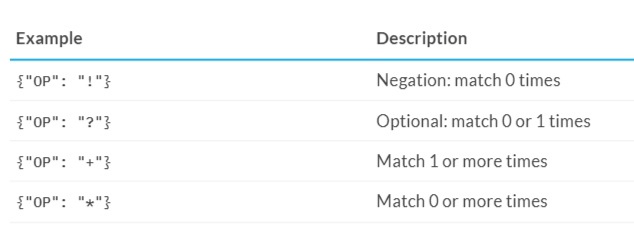

In the following example, the  `?` operator makes the determiner token optional, so it will match a token with the lemma "buy", an optional article and a noun.

In [ ]:
# we are looking for the following pattern
pattern = [{"LEMMA":"buy", "POS":"VERB"},  # first token is a lemma buy
           {"POS":"DET", "OP":"?"},        # second token is an optional determiner: match 0 or 1 times
           {"POS":"NOUN"}]                 # last token is a noun
matcher.add("OPT_PATTERN", [pattern])

# process some text
doc = nlp("I bought a smartphone. Now I'm buying apps")

# call the matcher on the doc, 
# BETTER If as_spans is set to True, a list of Span objects is returned instead.
matches = matcher(doc, as_spans=True)


print("Matches:", [i.text for i in matcher(doc, as_spans=True)]) # or matches

In [ ]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

doc = nlp(
    "Features of the app include a beautiful design, smart search, automatic "
    "labels and optional voice responses."
)

# Write a pattern for adjective plus one or two nouns
pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN", "OP": "?"}]

# Add the pattern to the matcher and apply the matcher to the doc
matcher.add("ADJ_NOUN_PATTERN", [pattern])
matches = matcher(doc, as_spans=True)
print("Total matches found:", len(matches))

# Iterate over the matches and print the span text
print("Matches:", [i.text for i in matcher(doc, as_spans=True)])

**Regular expressions with Rule-based Matcher**: In some cases, only matching tokens and token attributes **isn’t** enough – for example, you might want to match different spellings of a word, without having to add a new pattern for each spelling. For example:

``
pattern = [{"TEXT": {"REGEX": "^[Uu](\.?|nited)$"}},
           {"TEXT": {"REGEX": "^[Ss](\.?|tates)$"}},
           {"LOWER": "president"}]
``
> When using the `REGEX` operator, keep in mind that it operates on **single tokens**, not the whole text. Each expression you provide will be matched on a token. If you need to match on the whole text instead, see the details on [regex matching on the whole text](https://spacy.io/usage/rule-based-matching#regex-text).

We can also use`textacy`s **pattern-based phrase extraction**. In pattern, we can use the same patterns convention as `spaCy` or patterns separated by whitespace. The code below define a pattern to extract sequences of nouns with a preceding adjective:

In [ ]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = [{"POS": "ADJ"}, {"POS":"NOUN","OP":"+"}] # equivalent is ["POS:ADJ POS:NOUN:+"]

spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

# we use * before list comprehension to print elements without brackets
print(*[s.lemma_ for s in spans], sep='|')

Let's define a function to extract word sequences based on a defined pattern from  dataframe:

In [ ]:
# import the matcher
from spacy.matcher import Matcher

# load the pipeline and create the nlp object
nlp = spacy.load("en_core_web_sm")

# define rule-based matching function
def rb_match(df_name, col_name, pattern):

    # initialize the matcher with the shared vocab
    matcher = Matcher(nlp.vocab)
    # add the pattern to the matcher using .add method
    pattern_name = "PATTERN_%s" %col_name  
    matcher.add(pattern_name, [pattern])
    
    # process some text and store it in new column
    # use nlp.pipe for better performance 
    df_name['Text_spacy'] = [d for d in nlp.pipe(df_name[col_name])]
    
    # generate matches and store them in a new column
    df_name['matches'] = df_name['Text_spacy'].apply(lambda x: [i.text for i in matcher(x, as_spans=True)])    
    
    return df_name

Now, we can apply `rb_match` function on a simple dataframe for testing:

In [ ]:
details = {
    'Text_id' : [23, 21, 22, 21],
    'Text' : ['All roads lead to Rome. As laughter increases, respect decreases', 
              'All work and no play makes Jack a dull buy', 
              'Any port in a storm', 
              'Avoid a questioner, for he is also a tattler'],
}
  
# creating a Dataframe object 
example_df = pd.DataFrame(details)

rb_match(example_df, "Text", [{"POS":"NOUN"},{"POS":"VERB", "OP":"+"}])

#### Named-Entity Recognition (NER)
NER is the process of labelling “real-world” objects, like persons, companies or locations in text. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Named entities are available as the `ents` property of a `Doc`:

In [ ]:
# load the pipeline and create the nlp object
nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

print("Entities: ", [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents])

The `displaCy`  visualizer lets you explore an entity recognition model’s behavior interactively. If you’re training a model, it’s very useful to run the visualization yourself. To help you do that, spaCy comes with a visualization module. You can pass a `Doc` or a list of `Doc` objects to displaCy and run `displacy.serve` to run the web server, or `displacy.render` to generate the raw markup:

> **NOTE**: Because `spaCy` models are statistical and strongly depend on the examples they were trained on, this **doesn’t** always work perfectly and might need some tuning later, depending on your use case.

In [ ]:
from spacy import displacy

text = "When John Smith started working on laser projects at company, few people outside of the company took him seriously."

# load the pipeline and create the nlp object
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

displacy.render(doc, style="ent")

To extract named-entites of a certain types from dataframe, let's define a functin that make use of `textacy.extract.entities` function:

> **Important**: Here, We use this function with `apply` on a column containing `spaCy` documents. Be sure to process the text using `nlp` pipeline object before applying `extract_entities` function in this way.

In [ ]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [ ]:
# create new column containing PERSON and Geo-Political entities
example_df["NER"] = example_df["Text_spacy"].apply(extract_entities, [ "GPE"])
example_df

### Working on a Large Dataset

#### Enable GPU
`spaCy`s neural models benefit from running on GPU. Thus, we try to load the model on the GPU when we deal large datasets:

In [ ]:
if spacy.prefer_gpu():
    print("Working on GPU")
else:
    print("No GPU found")

#### Disable unneccesary components of Pipeline
As mentioned before, `nlp` by default runs the entire `spaCy` pipeline, which includes part-of-speech tagging, parsing and named entity recognition. We can significantly improve the runtime by by **disabling unneccesary parts** of the pipeline when you load the model as follows:

In [ ]:
# load the pipeline without tok2vec component and create the nlp object
nlp = spacy.load("en_core_web_sm", disable=["tok2vec"])

#### Using `spaCy`s batch processing `nlp.pipe()`

When processing large volumes of text, it is recommended to use `spaCy`s batch processing for a significant performance gain. The function `nlp.pipe` takes an *iterable of texts*, *processes* them internally as batch, and *yields* a list fo processed `Doc` objects in the same order as the input data.

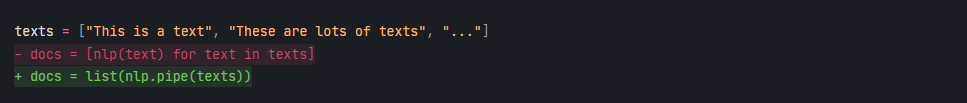

> **NOTE**: In any case, it is helpful to watch the progress and get a runtime estimate. The `tqdm` ibrary is a great tool for that purpose because it provides progress bars for iterators and dataframe operations.

---
Check `spaCy` documentation for more information about `nlp.pipe()`:
* [Language Processing Pipelines](https://spacy.io/usage/processing-pipelines)

---

To use `nlp.pipeline`, we **first** have to define a batch size. **Then** we can loop over the batches and call `nlp.pipe`. In the inner loop we **extract** the features from the processed `doc` and **write** the values back into the dataframe. :

> **IMPORTANT NOTE**: When using `nlp.pipe`, keep in mind that it returns a generator that yields `Doc` objects – **NOT** a list. So if you want to use it like a list, you’ll have to call `list()` on it first:

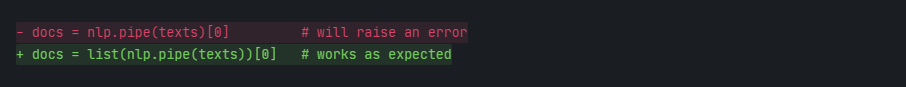

In [ ]:
import math 
from tqdm import tqdm

# define batch size
batch_size = 50
# define number of batches
batches = math.ceil(len(df) / batch_size) ###

# add empty column
df["text_spaCy"] = None

# loop over batches, step size is equal to batch size
for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['clean_text_textacy'][i:i+batch_size])
    df["text_spaCy"].iloc[i:i+batch_size] = list(docs) 
    
df["NER"] = df["text_spaCy"].apply(extract_entities, ["PERSON"])

In [ ]:
df.iloc[0:3]

In this notebook, we've seen how to gain early insights from textual data, how to build a text preprocessing pipeline to clean text, transform it, and extracting the basic features of textual data. The notebook provided a short introduction to the basics of text preprocessing with spaCy.